<a href="https://colab.research.google.com/github/RuTiO2le/SabiSAM/blob/f/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://huggingface.co/spaces/jbrinkma/segment-anything/resolve/main/sam_vit_b_01ec64.pth

--2023-11-01 17:02:14--  https://huggingface.co/spaces/jbrinkma/segment-anything/resolve/main/sam_vit_b_01ec64.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/24/38/24385625073145a1914991014f5db974993ea5767645b6f97548f270c8ebc0b6/ec2df62732614e57411cdcf32a23ffdf28910380d03139ee0f4fcbe91eb8c912?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_vit_b_01ec64.pth%3B+filename%3D%22sam_vit_b_01ec64.pth%22%3B&Expires=1699117334&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5OTExNzMzNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8yNC8zOC8yNDM4NTYyNTA3MzE0NWExOTE0OTkxMDE0ZjVkYjk3NDk5M2VhNTc2NzY0NWI2Zjk3NTQ4ZjI3MGM4ZWJjMGI2L2VjMmRmNjI3MzI2MTRlNTc0MTFjZGNmMzJhMjNmZmRmMjg5MTAzODBkMDMxMzllZ

In [ ]:
!pip install segment_anything

In [ ]:
from segment_anything import SamPredictor, sam_model_registry
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=ed0785526517f9708830ce42ad2c45406f26a96c12a7c543e2981f205fc2d5a6
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb

wandb.login() # 商用利用不可なので納品するモデルを作る場合は注意

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define dataset with masks
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mask_dir, transform=None):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_name)
        mask  = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask  = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to the size a model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization values for pre-trained PyTorch models
])

In [ ]:
base = "/content/drive/MyDrive/datasets/corrosion_condition_state_classification/512x512/Test"
path_to_images = os.path.join(base, "images_512")
path_to_masks  = os.path.join(base, "masks_512")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
wandb.init(
    project="stain_segmentetion",
    config={
    "learning_rate": 0.001,
    "model": "sam",
    "model_type": "vit_b",
    "checkpoint": "/content/sam_vit_b_01ec64.pth",
    "dataset": "stain_test",
    "epochs": 10,
    }
)
config = wandb.config

sam = sam_model_registry[config.model_type](checkpoint=config.checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

dataset = CustomDataset(root_dir=path_to_images, mask_dir=path_to_masks, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Fine-tuning the model
# predictor.sam.to(device)
# predictor.sam.train()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(predictor.parameters(), lr=config.learning_rate, momentum=0.9)

AttributeError: ignored

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")
optimizer = torch.optim.SGD(model.mask_decoder.parameters(), lr=config.learning_rate, momentum=0.9)

In [ ]:
dataset = CustomDataset(root_dir="images", mask_dir="mask", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
for epoch in range(config.epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # outputs = predictor(inputs)
        predictor.set_image(inputs[0])
        outputs, _, _ = predictor.predict(
            # point_coords=inputs,
            point_labels=labels,
            multimask_output=True,
        )
        predicted_masks = outputs.squeeze(1)
        loss = criterion(predicted_masks, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        wandb.log({"epoch": epoch, "loss": loss})

print('Finished Training')
wandb.finish()

ValueError: ignored

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.7 MB/s eta 0:00:00


In [ ]:
from transformers import SamModel

sam = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in sam.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seg_loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(sam.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

In [ ]:
# マスク画像をjpegに
mask_dir_name = os.path.join(base, "mask_512")
files = os.listdir(mask_dir_name)
number_of_exist_masks = []

for f in files:
    im = Image.open(os.path.join(mask_dir_name, f))
    im = im.convert("RGB")
    im.save(os.path.join(mask_dir_name, f"{f[:-4]}.jpeg"))
    number_of_exist_masks.append(int(f[:-4]))

In [ ]:
import shutil

os.mkdir("./images")
os.mkdir("./mask")

image_dir_name = os.path.join(base, "images_512")
files = os.listdir(image_dir_name)

for f in files:
    if int(f[:-5]) in number_of_exist_masks:
        shutil.copy(os.path.join(image_dir_name, f), "./images")

for i in number_of_exist_masks:
    shutil.copy(os.path.join(mask_dir_name, f"{i}.jpeg"), "./mask")

In [ ]:
from tqdm import tqdm

num_epochs = 20
dataset = CustomDataset(root_dir=path_to_images, mask_dir=path_to_masks, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

sam.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(dataloader):
      # forward pass
      outputs = sam(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/11 [00:00<?, ?it/s]


FileNotFoundError: ignored

In [ ]:
sam_model = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')
sam_model.to(device=device)
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters())
loss_fn = torch.nn.MSELoss()

with torch.no_grad():
	image_embedding = sam_model.image_encoder(input_image)

 with torch.no_grad():
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )

low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
)

upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

from torch.nn.functional import threshold, normalize

binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)

loss = loss_fn(binary_mask, gt_binary_mask)
optimizer.zero_grad()
loss.backward()
optimizer.step()

torch.save(model.state_dict(), PATH)

In [ ]:
from segment_anything import SamAutomaticMaskGenerator
import cv2
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry["vit_b"](checkpoint="/content/sam_vit_b_01ec64.pth")
sam.to(device=device)

mask_generator_ = SamAutomaticMaskGenerator(model=sam)

image = cv2.imread(os.path.join(path_to_images, "1.jpeg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side = 32,
    pred_iou_thresh = 0.980,
    stability_score_thresh = 0.96,
    crop_n_layers = 1,
    crop_n_points_downscale_factor = 2,
    min_mask_region_area = 100,
)

masks = mask_generator_.generate(image)

In [ ]:
from google.colab.patches import cv2_imshow

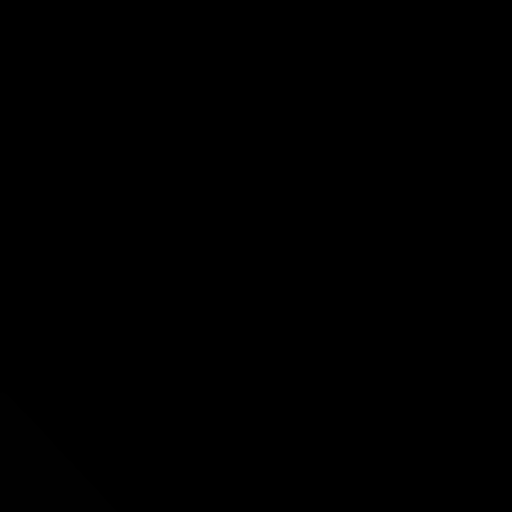

In [ ]:
cv2_imshow(masks[0]["segmentation"].astype(np.uint8))

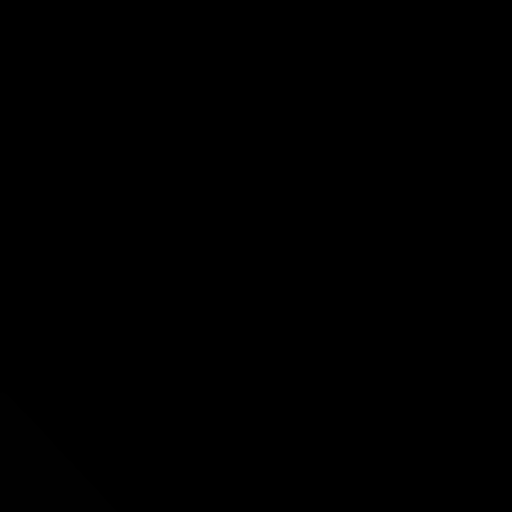

In [ ]:
Image.fromarray(masks[0]["segmentation"].astype(np.uint8))

In [ ]:
masks[0]["segmentation"]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

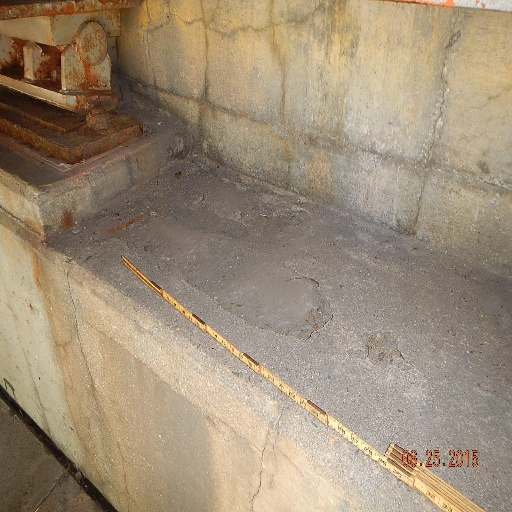

In [ ]:
Image.open(os.path.join(path_to_images, "1.jpeg"))

## 推論

19
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


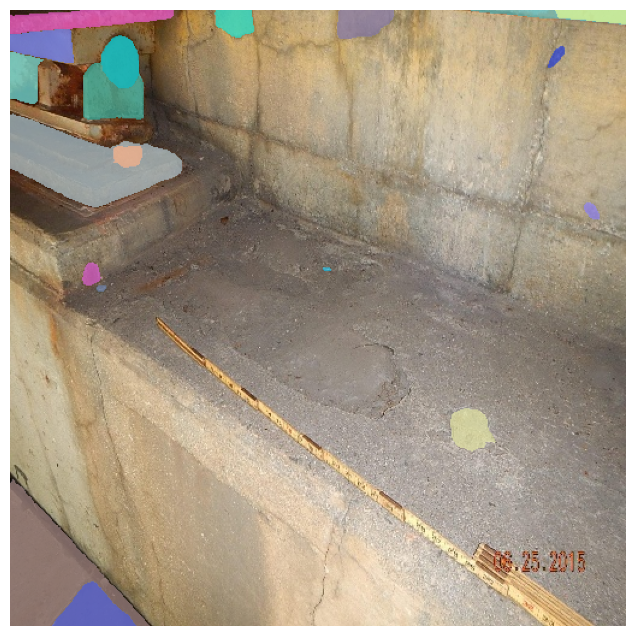

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return

    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*0.35)))

image = cv2.imread(os.path.join(path_to_images, "1.jpeg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(20,20))
# plt.imshow(image)
# plt.axis('off')

# sam_checkpoint = "sam_vit_h_4b8939.pth"

# device = "cuda"
# model_type = "default"

# import sys
# sys.path.append("..")
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())
plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

61
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


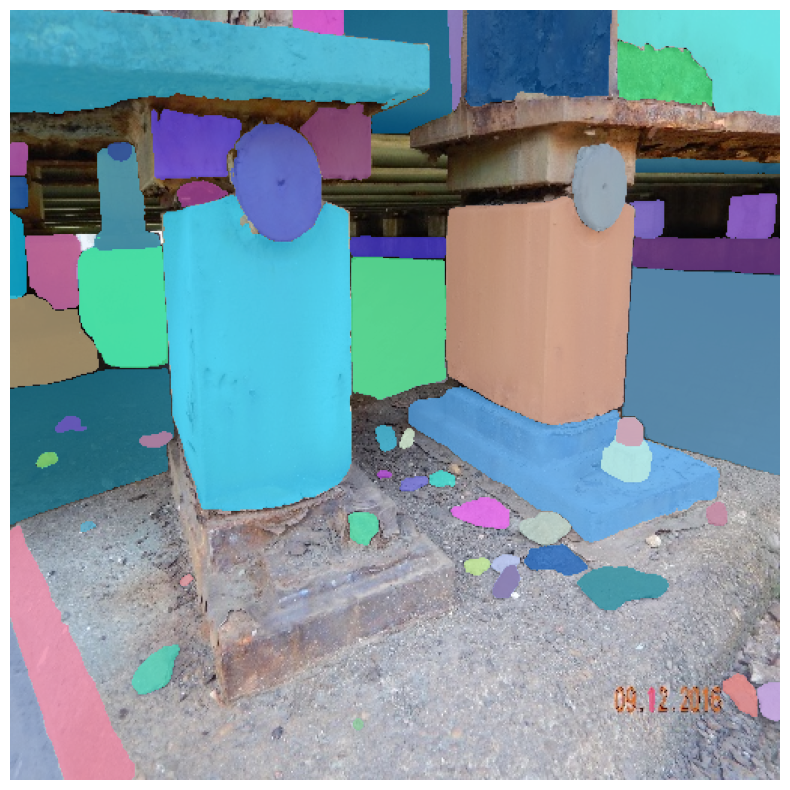

In [ ]:
image = cv2.imread(os.path.join(path_to_images, "2.jpeg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()